In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import itertools
import scipy
import time

In [2]:
# create an empty vector with a single component filled on a single line
def delta_vector(position, value=1,size=3):
    a = np.zeros(size)
    a[position] = value
    return a

### Original model

Below is an implementation of the original model, with the sole modification that initial opinions  
can take any value between 0 and 1, to reflect the case where a population is not initially polarized.

In [18]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=0.4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = np.random.uniform(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            cmap='RdBu',
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if np.random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = np.random.choice(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = list(self.graph.edges)[np.random.choice((range(len(self.graph.edges))))]
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

When gamma (coefficient of "pickiness" or "intolerance")is set takes low values, the population
tends to ammalgamate together with a uniform opinion.

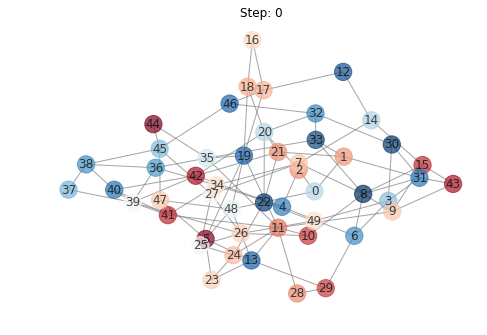

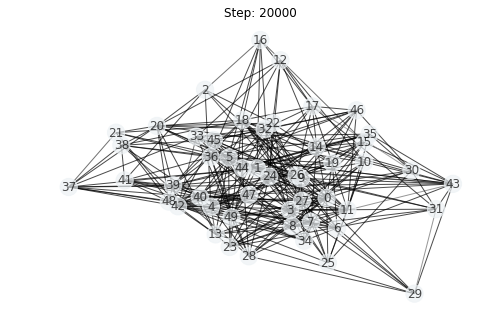

In [1334]:
sim = SocialDynamicsSimulation(beta=0.3, gamma=2)
plt.figure()
sim.observe()

for i in range(20000):
    sim.update()

plt.figure()
sim.observe()

plt.show()

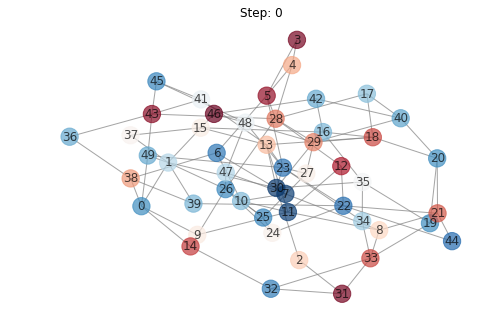

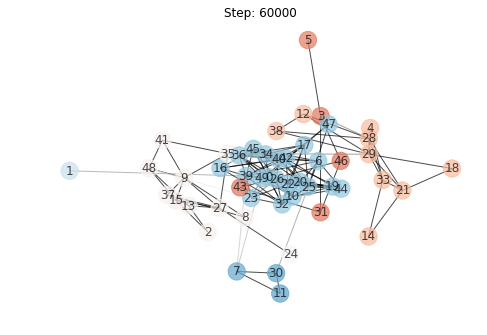

In [21]:
sim = SocialDynamicsSimulation(alpha=0.03,beta=0.3, gamma=20)
plt.figure()
sim.observe()

for i in range(60000):
    sim.update()

plt.figure()
sim.observe()

plt.show()

Given high values for gamma, the community will split into two main poles, with few or none remaining ties
between them. This is even exacerbated when starting values are 0 and 1.

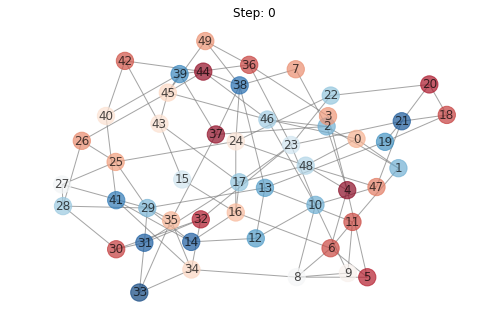

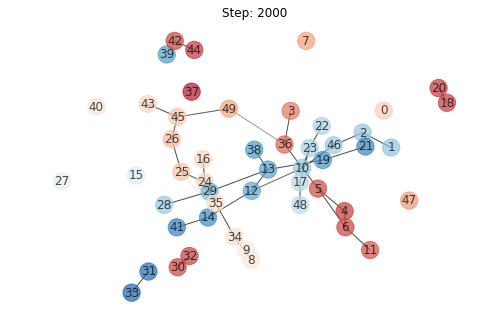

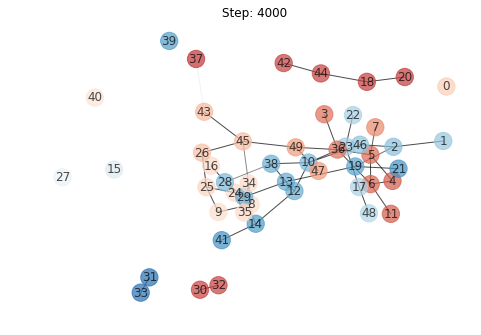

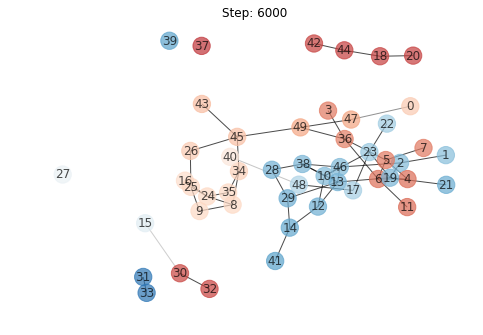

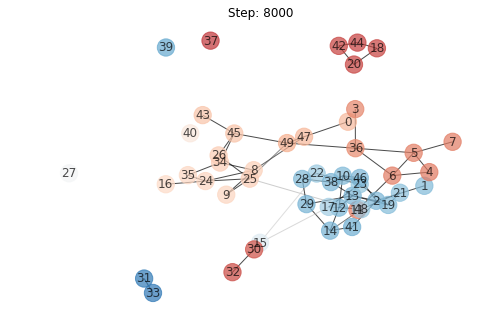

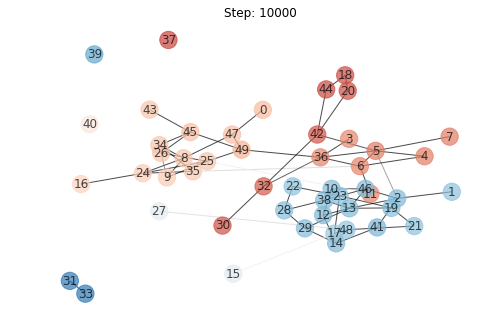

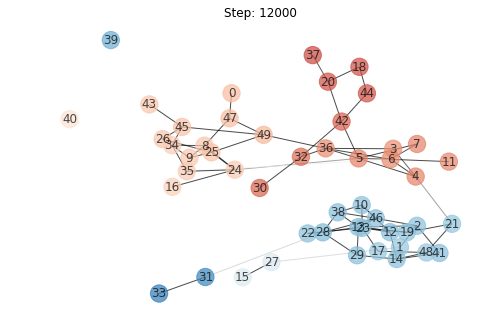

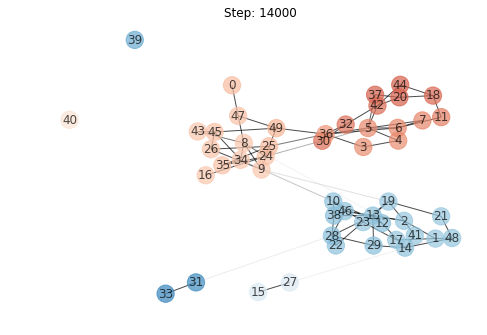

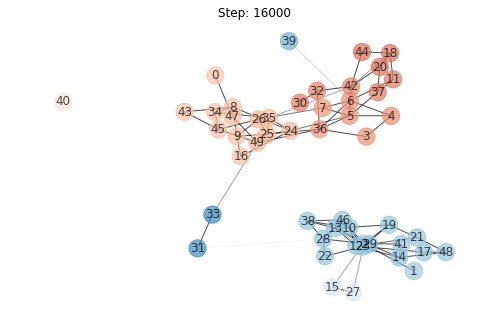

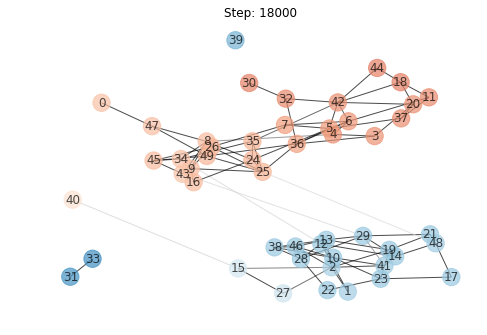

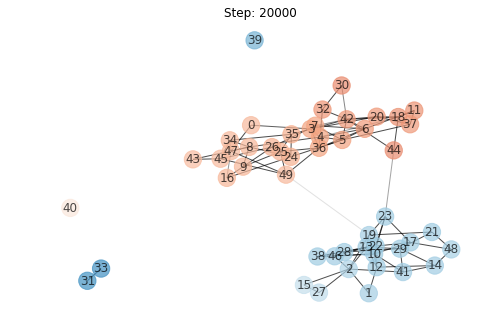

In [333]:
sim = SocialDynamicsSimulation(gamma=10)
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

plt.show()

I implemented the following extensions to the model

* Multiple opinions.


* The opinion vector is sampled from a truncated (0,1) trivariate normal distribution to model the observed correlation   between political opinions (e.g. let 0 be conservative opinions and 1 be liberal views about each topic). The multivariate distribution takes a single parameter "correlated" (r). The  
 sampling assumes the three opinions  have identical standard deviations, and the covariance between each  pair is calculated from the pearson's  
 r coefficient given by the user. For all simulations performed I will use a correlation of 0.5, an arbitrary value I expect to represent the level of polarization present in the United States. The mean of the distribution is [.5 .5 .5]T.
 
* An acceptance process prior to engagement in conversation. Probability of acceptance is given by p = 0.1**(d(i,j)/delta). Delta is a simulation parameter associated with the acceptance of global differences. 

* If two individuals accept to talk, they will only do so in the topic of least disagreement. This is intended to model the phenomenon of two individuals resorting to agreeability to "break the ice" with someone who might be otherwise very different to them.

### Extended model

In [3]:
class MultivarSocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.075, beta=0.3, gamma=4, delta=1, 
                 correlated = 0.5, p_add = 0.005, only_most_agreed=False, normal_sampling = True,
                clustered_edges = False, colored_edges = False):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
              
            
            delta (float) The openness of each individual to global differences. It affects the
            probability of an individual rejecting another prior to having a conversation.
            
            normal_sampling (boolean) If true, sample opinions from a multivariate distribution
            with mean [0.5 0.5 0.5]T and SD 0.25 for each individual opinion. If false, sample
            each opinion component as either 0 or 1 with equal probability.
            
            correlated (float) [0-1] It defines the correlation between pairs of opinions when
            sampled from a multivariate normal distribution.
            
            p_add (float) [0-1] It defines the probability of adding a new edge to the network.
            
            only_most_agreed (boolean) If true, conversations are about a single topic, the one
            where both speakers disagree the least.
            
            clustered_edges (boolean) If true, sample candidate edges using the method
            MultivarSocialDynamicsSimulation.sample_new_edge(). This method was not implemented
            in the present paper due to it hindering openmindedness and creating too much 
            clustering.
            
            colored_edges (boolean) If true, color edges according to the least disagreed topic
            between two nodes.
                
              
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.correlated = correlated
        self.p_add = p_add
        self.only_most_agreed = only_most_agreed
        self.normal_sampling = normal_sampling
        self.clustered_edges = clustered_edges
        self.colored_edges = colored_edges
    
    def sample_opinions(self):
        #opinions are sampled according to the following trivariate normal distribution,
        #
        
        #multivariate mean (of each opinion)
        meanm = [0.5,0.5,0.5]
        
        #standard deviation of each opinion
        cov_jj = 0.25
        
        #covariance between each pair of opinions
        cov_ij = cov_jj**2 * self.correlated
        
        #covariance matrix
        covm = np.array([[cov_jj,cov_ij,cov_ij],
                        [cov_ij,cov_jj,cov_ij],
                        [cov_ij,cov_ij,cov_jj]])
        
        
        p = np.array([-1,-1,-1])
        #truncation by rejection.
        while np.any(p<0) or np.any(p>1):
            p = np.random.multivariate_normal(mean=[0.5,0.5,0.5],cov=covm,size=1)[0]
        
        return p
        
    # NOTE: Not implemented due to it leading to too many loners!
    def sample_new_edge(self):
        n_nodes = self.graph.number_of_nodes()
        cn = np.zeros((n_nodes,n_nodes)) #matrix of common neighbors
        dm = np.zeros((n_nodes,n_nodes)) #matrix of distances

        for i,m in enumerate(self.graph.nodes):
            for j,n in enumerate(self.graph.nodes):
                #return the number of common neighbors between two nodes
                cn[i,j] = len(list(nx.common_neighbors(self.graph,m,n)))
                try:
                    # if distance is zero, return NaN (we don't want self-edges)
                    dm[i,j] = nx.shortest_path_length(self.graph,m,n) if nx.shortest_path_length(self.graph,m,n)!= 0 else np.nan
                except:
                    # if there is no shortest path, distance is infinite
                    dm[i,j]= np.inf

        #matrix of sampling probabilities
        samp_probs = np.zeros(cn.shape)

        #for each cell of the matrix
        for i in itertools.product(range(n_nodes),range(n_nodes)):


            # set the probability of creating an edge between two nodes of a connected component
            # as (c+1)/(d-1).
            # set the probability of creating an existing edge (d=1) as nan
            samp_probs[i] = (cn[i]+1)*(1/1)/(dm[i]-1) if (cn[i]+1)/(dm[i]-1) != np.inf else np.nan

        smallest_prob = min([n for n in np.unique(samp_probs) if n > 0])

        for i in itertools.product(range(n_nodes),range(n_nodes)):
            if samp_probs[i] == 0:
                samp_probs[i] = smallest_prob/2
                #samp_probs = samp_probs#/np.nansum(samp_probs)*0.9
        samp_probs = samp_probs/np.nansum(samp_probs)*2


        samp_df = pd.DataFrame([(c,samp_probs[c]) for c in itertools.combinations_with_replacement(range(n_nodes),2) if not np.isnan(samp_probs[c])])

        samp_roulette = np.cumsum(samp_df.iloc[:,1])
        sampled_edge = samp_df.iloc[samp_roulette.searchsorted(np.random.uniform(0, 1))[0],0]

        return sampled_edge
        
    
    def initialize(self):
#         '''
#         Initialize the simulation with a random graph, with random 0 or 1
#         opinions assigned to all nodes and initial edge weights of 0.5.
#         '''
        
        # for local analysis, start the graph as K2
        if self.network_size == 2:
            self.graph = nx.complete_graph(n=2)
        
        # otherwise, set the initial graph as a small world network
        elif self.network_size > 2:
            self.graph = nx.watts_strogatz_graph(self.network_size, 5, 0.5)
        
        # all weights are initialized as 0.5
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        
        
        #decide method of sampling opinions: normally or discretely from [0,1] 
            
        if self.normal_sampling:
            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = self.sample_opinions()
        else:
            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = np.random.randint(0,2,3)
        
        
        #self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0


        
    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=10)
        plt.clf()
        
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            #cmap='RdBu',
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1)
            #alpha=0.7, vmin=0, vmax=1)
        
        if self.network_size == 2:
            opinions = [self.graph.nodes[n]['opinion'] for n in self.graph.nodes]
            plt.title('Step: ' + str(self.step) + '\n' + 'Euclidean distance between opinions: ' + str(np.linalg.norm(opinions[1] - opinions[0])))
        elif self.network_size > 2:
            plt.title('Step: ' + str(self.step) + '\n' + 'Dispersion: ' + str(self.dispersion()))
        else:
            raise 'Network Size error'

            
    def observe_custom(self, ax=plt.gca(), layout='spring'):
        '''
        Draw the state of the network with custom axis or layout.
        
        ax (matplotlib Axis) : axis 
        layout (string) : layout mode for network nodes
        
        '''
        if layout == 'spring':
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=25, 
                                           k= 12/self.network_size)
        elif layout == 'shell':
            self.layout = nx.shell_layout(self.graph)
        elif layout == 'spectral':
            self.layout = nx.spectral_layout(self.graph)
        elif layout == 'circular':
            self.layout = nx.circular_layout(self.graph)
        else:
            self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        
        opinions = [self.graph.nodes[n]['opinion'] for n in self.graph.nodes]

            
        #create an RGBA vector whose color corresponds to the least disagreed topic and its alpha
        #to the weight of the bond
        if self.colored_edges:    
            color_for_edges = [delta_vector(position = np.argmin(abs(opinions[i] - opinions[j])), size=4) + \
                               self.graph.edges[i, j]['weight'] * delta_vector(position=3, size=4) \
                               for i,j in self.graph.edges]
        else:
            
            # use the weight and the default cmap for coloring edges
            color_for_edges =[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges]
            
        nx.draw_networkx(
            self.graph, pos=self.layout, with_labels=True, ax=ax,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color = color_for_edges)
        
        
        # for local analysis, use Euclidean distance as subtitle
        if self.network_size == 2:
            opinions = [self.graph.nodes[n]['opinion'] for n in self.graph.nodes]
            ax.set_title('Step: ' + str(self.step) + '\n' + 'Euclidean distance between opinions: ' + str(np.linalg.norm(opinions[1] - opinions[0])))
        elif self.network_size > 2:
        #otherwise, use the determinant dispersion method defined below
            ax.set_title('Step: ' + str(self.step) + '\n' + 'Dispersion: ' + str(self.dispersion()))
        else:
            raise 'Network Size error'
        
        ax.axis('off')
        
    # how similar are people globally? (multivar generalization of SD)
    def dispersion(self):
        covdet = np.linalg.det(np.cov(np.array([self.graph.nodes[x]['opinion'] for x in self.graph.nodes]), rowvar=False))
        return math.log(self.network_size,1/covdet)
    
    # how many elements are out of the largest component?
    def len_out_largest_comp(self):
        return self.network_size - len(max(nx.connected_component_subgraphs(self.graph), key=len))
    
    # how many elements are in connected componetns with size > 3?
    def in_large_conn_component(self):
        return sum([len(g) for g in nx.connected_component_subgraphs(self.graph) if len(g) > 3])/self.network_size
    
    # what is the average degree of the network?
    def average_degree(self):
        return 2*nx.number_of_edges(self.graph)/nx.number_of_nodes(self.graph)
    
    def n_large_connected_components(self):
        return len([c for c in nx.connected_components(sim.graph) if len(c) > 3])
    
    def update(self):
        if np.random.uniform(0, 1) < self.p_add:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            
            if self.clustered_edges:
                new_edge = self.sample_new_edge()
                self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
            else:
                while True:
                    new_edge = np.random.choice(nodes, 2)
                    if new_edge not in self.graph.edges:
                        break
                self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            
            try: # skip if no edges left
                edge = list(self.graph.edges)[np.random.choice((range(len(self.graph.edges))))]

                
                weight = self.graph.edges[edge]['weight']
                opinions = [self.graph.nodes[n]['opinion'] for n in edge]
                
                #difference vector for two individuals' opinions
                opinions_difference = opinions[1] - opinions[0]
                
                #topic with least absolute difference between two individuals
                most_agreed = np.argmin(abs(opinions[1] - opinions[0]))


                #Euclidean distance between two individuals' opinion vectors
                opinions_distance = np.linalg.norm(opinions[1] - opinions[0])

                
                #definition of p_acceptance(i,j,delta)
                p_acceptance = 0.1**(opinions_distance/self.delta)


                if np.random.random() < p_acceptance:

                    for i in [0, 1]:
                        if self.only_most_agreed:
                            #only affect the topic of discussion, leave the rest the same
                            delta_opinion = np.zeros(3)
                            delta_opinion[most_agreed] = opinions[1-i][most_agreed] - opinions[i][most_agreed]
                        else:
                            delta_opinion = opinions[1-i] - opinions[i]

                        self.graph.nodes[edge[i]]['opinion'] = (
                            opinions[i] + self.alpha * weight * delta_opinion)
                    self.graph.edges[edge]['weight'] = ( 
                                    weight + self.beta * weight * (1-weight) *
                        #set maximal distance to sqrt(3) (the distance between [0 0 0] and [1 1 1])
                                    (1 - self.gamma * opinions_distance/np.sqrt(3)))
                    # Remove very weak connections
                    if self.graph.edges[edge]['weight'] < 0.05:
                        self.graph.remove_edge(*edge)

                else:
                    #pass
                    self.graph.edges[edge]['weight'] = 0.9*weight
        
            except:
                pass #print('Warning: No edges left! Antisocial behavior detected')
        self.step += 1


### Local Analysis

I plotted several vector field for different values of gamma and delta to test their influence on the
predicted equilibria, critical points and attractors.

Correction on original assignment: 
* Where it read delta(o)=gamma, it should have read gamma=1/delta(o).
* Where it read E[w\*] = w[0.9 - 0.1^(d/delta), it should have read E[w\*] = w[0.9 + 0.1^(1+d/delta)]
* Thus, there is no positive delta that determines equilibrium independently from gamma on either dimension.
* Where it read E(∆o) = 0.1^(d/delta) \* alpha \* w \* diff_opinion, it should have read 
 E(∆o) = 0.1^(d/delta) \* alpha \* E[w\*] \* diff_opinion
 

* The expected change in weights is  
 E(∆w) = (1 - p_acceptance)(-0.1w) + p_acceptance\*(beta\*w)(1-w)(1-gamma\*diff_opinion)  
 E(∆w) = (1 - 0.1^(d/delta))(-0.1w) + 0.1^(d/delta)\*(beta\*w)(1-w)(1-gamma\*diff_opinion)
 


The following vector field plot treats probabilistic factors as in expectation and assumes that two components of the opinion vector have a constant difference of 0.5 between the two individuals.
Thus, d(i,j) = √(0.5 + diff_opinion^2).


Green trajectories indicate situations in which the two individuals resolve to befriend each other and either agree or reach stable opinion differences. Purple indicates the bond eventually breaks. Light blue is a sign of stack overflow which should be fixed in a next iteration.

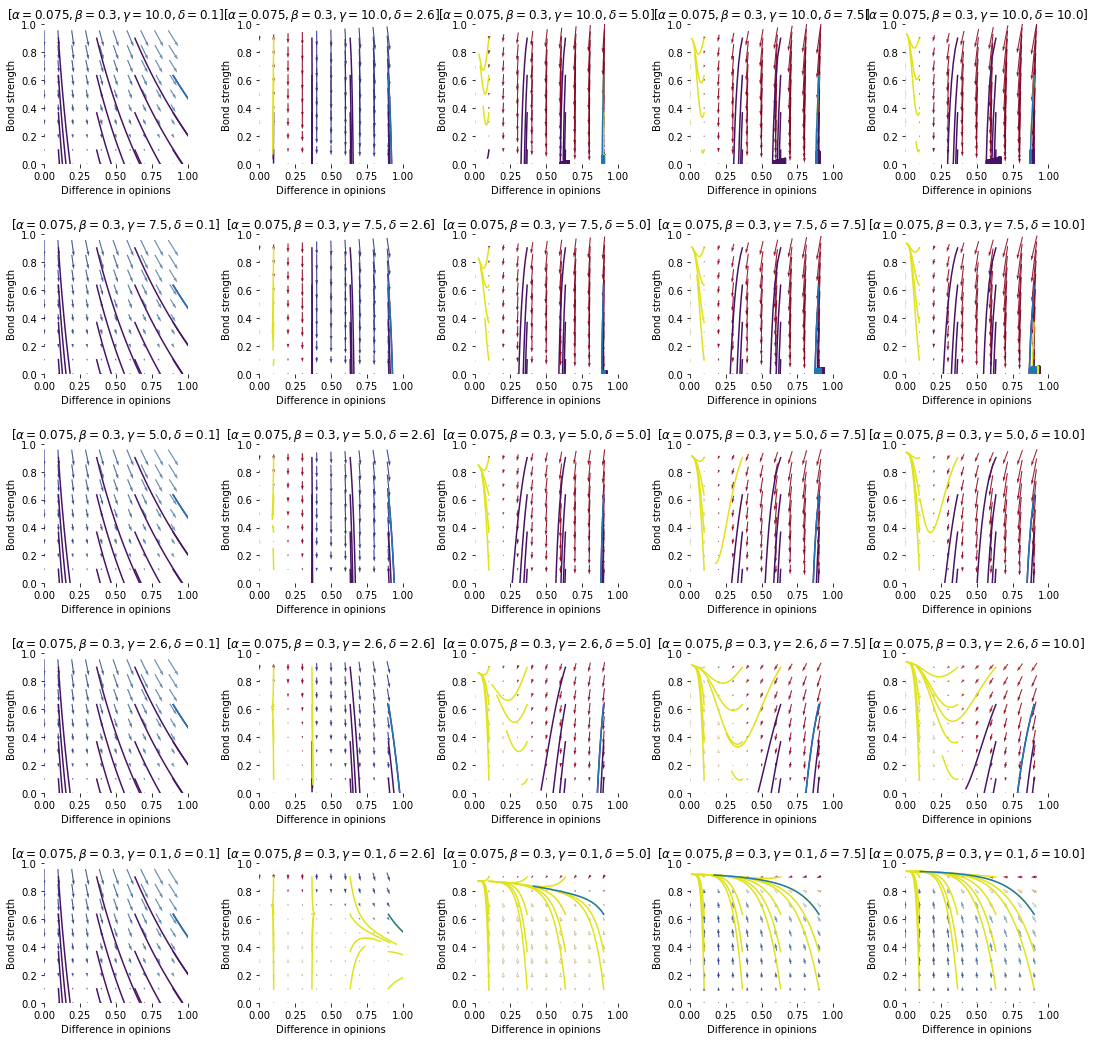

In [203]:
alpha = 0.075
beta = 0.3
gamma = 1
delta = 0.1

n_plots = 5
cmap = plt.cm.viridis


# ranges of gammas and deltas
gammas = np.linspace(0.1,10,n_plots)
deltas = np.linspace(0.1,10,n_plots)


diffop, bond = np.meshgrid(np.arange(0, 1, .1), np.arange(0, 1, .1))


fig, axes = plt.subplots(n_plots,n_plots,figsize=(18,18))

distanceops = 2

#delta_w = beta*

#(1 - 0.1**(np.sqrt(0.5+diffop**2)/deltas[j])(-0.1*bond) + 0.1**(np.sqrt(0.5+diffop**2)/deltas[j]) * beta * bond * (1 - bond) * (1 - gammas[g] *abs(diffop))

for i,g in enumerate(gammas):
    for j,d in enumerate(deltas):
        # expected change in o
        delta_o = -1*0.1**(np.sqrt(0.5+diffop**2)/deltas[j]) * alpha*diffop*bond*(0.9+0.1**(1+np.sqrt(0.5+diffop**2)/deltas[j])) + (1-0.1**(np.sqrt(0.5+diffop**2)/deltas[j]))* alpha*diffop*bond*(0.9+0.1**(1+np.sqrt(0.5+diffop**2)/deltas[j]))
        # expected change in w
        delta_w = (1 - 0.1**(np.sqrt(0.5+diffop**2)/deltas[j]))*(-0.1*bond) + 0.1**(np.sqrt(0.5+diffop**2)/deltas[j]) * beta * bond * (1 - bond) * (1 - gammas[i] * abs(diffop))
        #delta_w = beta*bond*(0.9-0.1**(np.sqrt(0.5+diffop**2)/deltas[j]))*(1-bond*(0.9-0.1**(np.sqrt(0.5+diffop**2)/deltas[j])))*(1-gammas[i]*abs(diffop))
        
        axes[n_plots-1 - i,j].set_title(r'[$\alpha={},\beta={},\gamma={}, \delta={}$]'.format(alpha,beta,round(gammas[i],1),round(deltas[j],1),
                           fontsize=2))
        axes[n_plots-1 - i,j].quiver(diffop, bond, delta_o, delta_w, #units='width',
                                    np.arctan2(delta_o, delta_w), angles='xy', scale_units='xy',
                                    scale=.8, pivot='mid', cmap='RdYlBu', edgecolor='k',
                                    linewidth=0.1)#,color='g')

        axes[n_plots-1 - i,j].set_xlabel('Difference in opinions')
        axes[n_plots-1 - i,j].set_ylabel('Bond strength')
        axes[n_plots-1 - i,j].spines['top'].set_visible(False)
        axes[n_plots-1 - i,j].spines['right'].set_visible(False)
        axes[n_plots-1 - i,j].spines['bottom'].set_visible(False)
        axes[n_plots-1 - i,j].spines['left'].set_visible(False)
        axes[n_plots-1 - i,j].set_xlim(0,1)
        axes[n_plots-1 - i,j].set_ylim(0,1)
        
        
        # plot trajectories with conditional colors
        
        for n in range(16):
            if n == 15: continue
            T = 50
            trajectory = np.zeros((T,2))
            dop_0,bnd_0 = list(itertools.product(np.linspace(0.1,0.9,4),np.linspace(0.1,0.9,4)))[n]
            for t in range(T):

                trajectory[t,0] = dop_0
                trajectory[t,1] = bnd_0
                

                #do = alpha*dop_0*bnd_0
                do = -1*0.1**(np.sqrt(0.5+dop_0**2)/deltas[j]) * alpha*dop_0*bnd_0*(0.9+0.1**(1+np.sqrt(0.5+dop_0**2)/deltas[j])) + (1-0.1**(np.sqrt(0.5+dop_0**2)/deltas[j]))* alpha*dop_0*bnd_0*(0.9+0.1**(1+np.sqrt(0.5+dop_0**2)/deltas[j]))
                
                dw = (1 - 0.1**(np.sqrt(0.5+dop_0**2)/deltas[j]))*(-0.1*bnd_0) + 0.1**(np.sqrt(0.5+dop_0**2)/deltas[j]) * beta * bnd_0 * (1 - bnd_0) * (1 - gammas[i] * abs(dop_0))
                #dw = beta*bnd_0*(0.9-0.1**((np.sqrt(dop_0**2 + np.sqrt(0.5+dop_0**2)))/deltas[j]))*(1-bnd_0*(0.9-0.1**((np.sqrt(dop_0**2 + np.sqrt(0.5+dop_0**2)))/deltas[j])))*(1-gammas[i]*abs(dop_0))

                dop_0 = dop_0 + do
                bnd_0 = bnd_0 + dw
                
                if bnd_0 < 0:
                    bnd_0 = -0.1
                if bnd_0 > 1:
                    bnd_0 = 1.1
                    

            
            if np.any(trajectory[t,1]<0.05):
                axes[n_plots-1 - i,j].plot(trajectory[:,0], trajectory[:,1], color = cmap(0.05))
            elif np.any(trajectory[t,1]>1):
                axes[n_plots-1 - i,j].plot(trajectory[:,0], trajectory[:,1], color = cmap(0.75))
            else:
                axes[n_plots-1 - i,j].plot(trajectory[:,0], trajectory[:,1], color = cmap(0.95))
                

        
        axes[n_plots-1 - i,j].plot(trajectory[:,0], trajectory[:,1])

plt.subplots_adjust(hspace=0.5, wspace = 0.5)
plt.show()

As it can be observed, when alpha=0.075, beta=0.3, gamma=5, 
difference in opinions about one topic = 0.366 and bond strength = 0.9,
there is a critical point between delta = 5 and delta = 7.5 that determines whether the two individuals will agree and befriend each other or cut their ties. While on my the paper I submitted I determined that gamma and delta determined equilibria of the system independently, there is a clear interaction of the parameters to determine the fate of the system (at the described set of parameters and initial conditions, either decreasing gamma or increasing beta leads to individuals befriending each other rather than cutting their ties; thus the value of gamma influences the delta needed for the individuals to befriend each other and vice versa).

### Testing prediction of critical point from Vector field plot

alpha = 0.075, beta=0.3, gamma=5,
∆o_3 = 0.3666, w = 0.9

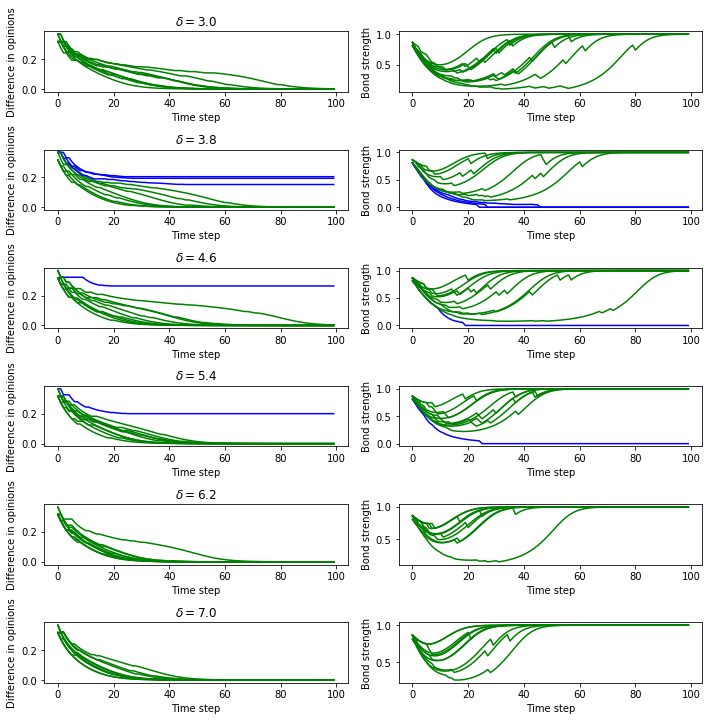

In [211]:
#try the following deltas keeping gamma and everything else constant
deltas = np.linspace(3,7,6)
fig, axes = plt.subplots(6,2, figsize=(10,10))


for idx,delta in enumerate(deltas):
    for r in range(10):
        opinion_evo = []
        bond_evo = []

        sim = MultivarSocialDynamicsSimulation(network_size=2, alpha=0.075, beta=0.3, gamma=5,delta=delta,correlated = 0.4, p_add = 0)
        sim.initialize()

        sim.graph.edges[0,1]['weight'] = 0.9
        sim.graph.nodes[0]['opinion'] = np.array([0,0,1])
        sim.graph.nodes[1]['opinion'] = np.array([0.5,0.5,1-0.36666667])

        for i in range(100):
            sim.update()
            
            #append weight and difference in an opinion to a list to be plotted
            try:
                bond_evo.append(sim.graph.edges[0,1]['weight'])
            except:
                bond_evo.append(0)
            opinion_evo.append(abs(sim.graph.nodes[0]['opinion'][2]-sim.graph.nodes[1]['opinion'][2]))

        axes[idx,0].plot(range(100),opinion_evo,
                        color = 'green' if bond_evo[-1] > 0.9 else 'blue')
        axes[idx,1].plot(range(100),bond_evo,
                                     color = 'green' if bond_evo[-1] > 0.9 else 'blue')
        
        axes[idx,0].set_title(r'$\delta={}$'.format(delta))
        axes[idx,0].set_xlabel('Time step')
        axes[idx,1].set_xlabel('Time step')
        
        axes[idx,0].set_ylabel('Difference in opinions')
        axes[idx,1].set_ylabel('Bond strength')

plt.tight_layout()

plt.show()


This simulation suggests that this set of parameters and initial conditions there is a critical point between 5.4 and 6.2, which somewhat resembles our expectations of a critical point between 5 and 7.5. We must take into account that bonds are very unstable at weights below 0.2, and thus sensitive to the intrinsic stochasticity of the system, which explains why around the critical values some bonds recover from the initial fall and others do not. The simulation also matches our expectations about the difference of opinions in equilibrium (approximately 0.2).

## Simulation analysis

### Question 0: What values of alpha best preserve opinion diversity?

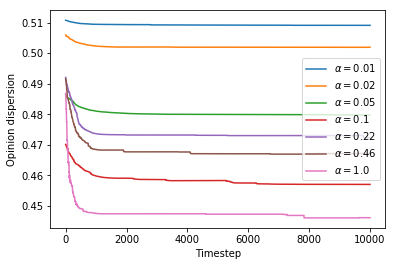

In [1064]:
alphas = np.logspace(-2,0,7)

dispersions = np.zeros((7,10000))

for i,a in enumerate(alphas):
    sim = SocialDynamicsSimulation(alpha=a,gamma=g,delta=d,correlated=correl)
    sim.initialize()
    for _ in range(10000):
        sim.update()
        dispersions[i,_] = sim.dispersion()

for d in range(7):
    plt.plot(dispersions[d],label=r'$\alpha={}$'.format(round(alphas[d],2)))
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Opinion dispersion')
#plt.yscale('log')
plt.show()



Answer: The rate of change in opinions affects the stable opinion dispersion significantly, yet its effect size is small enough to be negligible. For the following simulations, I will use alpha = 0.075 and beta = 0.3. Optimal values for gamma and delta will be determined by observing their effect on the global state of the simulation through several heatmaps, and comparing these observations with the predictions of the local analysis. The probability of adding a new edge will be left arbitrarily as 0.001.

### Question 1: Does correlation between variables affect final dispersion of opinions?

Opinion dispersion vs Pierson's r between opinions at inialization


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:301: RuntimeWarning: invalid value encountered in double_scalars


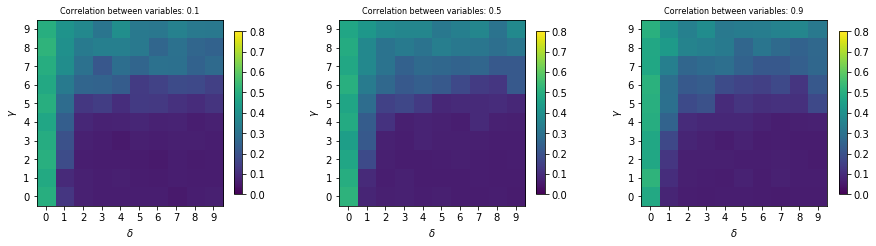

Runtime: 151.16 s.


In [7]:
start = time.time()
gammas = np.linspace(0,10,10)
deltas = np.linspace(0,10,10)
correl = np.linspace(0.1,0.9,3)

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
imshows = 3*['']

print("Opinion dispersion vs Pierson's r between opinions at inialization")

fig, axes = plt.subplots(1,3,figsize=(15,10))

for k,ax in enumerate(axes.flatten()):
    start = time.time()
    for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl[k])
            sim.initialize()
            for _ in range(10000):
                sim.update()
            dispersions[i,j] = sim.dispersion()
    
    imshows[k] = ax.imshow(dispersions,origin='lower',vmin=0,vmax=0.8)
    ax.set_xticks(range(0,10,1))
    ax.set_yticks(range(0,10,1))
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    ax.set_title('Correlation between variables: {}'.format(str(correl[k])[:3]),fontsize=8)

plt.subplots_adjust(hspace=-0.45,wspace=0.3)#0.01,0.4,0.1,0.5)

for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=ax,shrink=0.3)


plt.show()
print('Runtime: {} s.'.format(round(time.time() - start,2)))

Answer: No.
    
### Question 2: How do the values of gamma and delta affect the evolution of opinions and the topology of the network?

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars


5.0% done
10.% done
15.% done
20.% done
25.% done
30.% done
35.% done
40.% done
45.% done
50.% done
55.% done
60.% done
65.% done
70.% done
75.% done
80.% done
85.% done
90.% done
95.% done
100% done


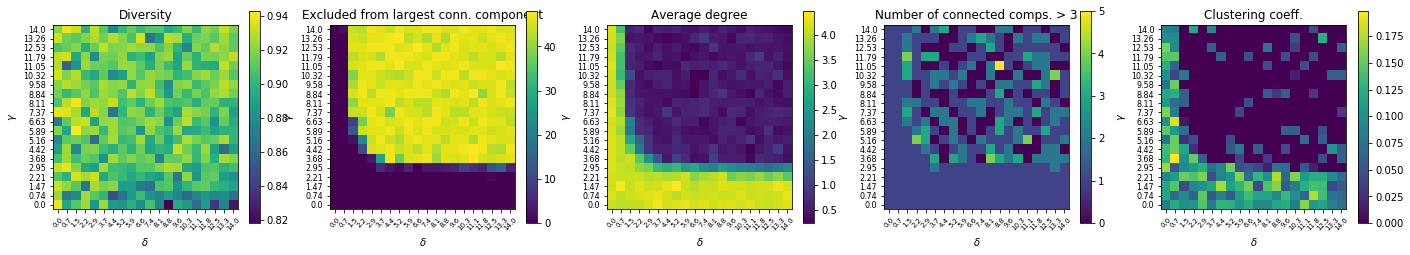

In [1346]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,only_most_agreed= True, network_size=50)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([dispersions,largest_components,avgdegs,nlcs,clus])
titles = ['Diversity','Excluded from largest conn. component', 'Average degree', 'Number of connected comps. > 3', 'Clustering coeff.']
# imshows = ['','','','','']

fig, axes = plt.subplots(1,5,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:5]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=axes[i],shrink=0.15)

# #plt.tight_layout()
plt.show()





Answer: With the tested parameters, there seem to be two attractors. The state shown in the upper right of the last 4 subfigures represents the state of almost no bonds existing between individuals. The state below and on the extreme left of these figures represents the state of a netwoerk where all individuals are part of the largest connected component, with various levels of clustering. Diversity of opinions seems to be uncorrelated with either parameter, although the highest levels of diversity seem to arise within the basin of the top-right attractor, and the lowest levels occur with gamma < 1.


### Question 3: Does the most agreed criterion prevent opinions from becoming too narrow or too diverse?

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in double_scalars


5.0% done
10.% done
15.% done
20.% done
25.% done
30.% done
35.% done
40.% done
45.% done
50.% done
55.% done
60.% done
65.% done
70.% done
75.% done
80.% done
85.% done
90.% done
95.% done
100% done


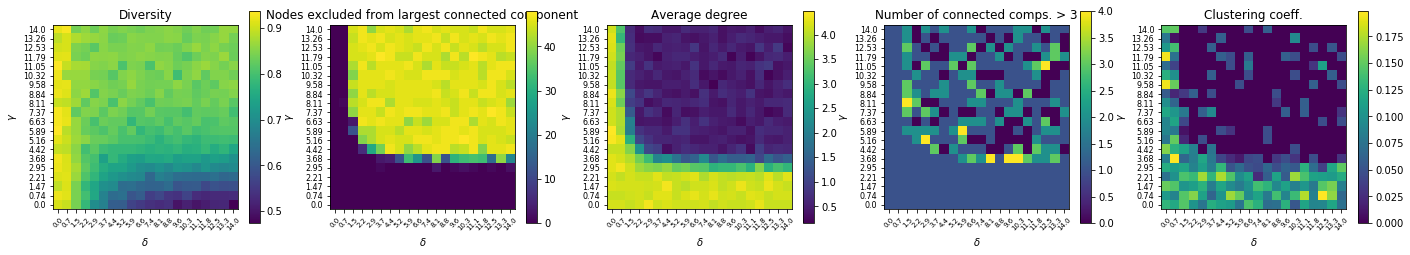

In [1345]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                   most_agreed_only= False, network_size=50)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([dispersions,largest_components,avgdegs,nlcs,clus])
titles = ['Diversity','Excluded from largest conn. component', 'Average degree', 'Number of connected comps. > 3', 'Clustering coeff.']
# imshows = ['','','','','']

fig, axes = plt.subplots(1,5,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:5]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=axes[i],shrink=0.15)

# #plt.tight_layout()
plt.show()




Answer: Yes. Restricting discussion to the least disagreed topic maintains opinion diversity even when individuals are not picky with others' opinions (by not letting their opinions' on other topics be affected when there is serious disagreement about them).

### Question 4: Are initial conditions relevant for the determination of the phase portrait?
To answer this, I will run the simulation as in the original model, where each opinion is initialized as either 0 or 1.

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars


5.0% done
10.% done
15.% done
20.% done
25.% done
30.% done
35.% done
40.% done
45.% done
50.% done
55.% done
60.% done
65.% done
70.% done
75.% done
80.% done
85.% done
90.% done
95.% done
100% done


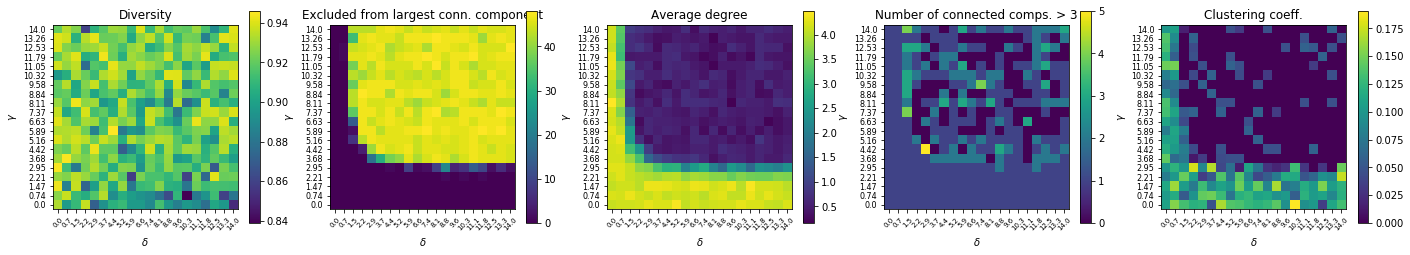

In [1347]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                   network_size=50, only_most_agreed = True,
                                                   normal_sampling = False)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([dispersions,largest_components,avgdegs,nlcs,clus])
titles = ['Diversity','Excluded from largest conn. component', 'Average degree', 'Number of connected comps. > 3', 'Clustering coeff.']
# imshows = ['','','','','']

fig, axes = plt.subplots(1,5,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:5]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=axes[i],shrink=0.15)

# #plt.tight_layout()
plt.show()



Answer: There are no significant changes with respect to normally distributed opinions.

Interestingly enough, for all simulation choices,  largest numbers of clusters (>3) occur more often at the L-shaped phase transition for all simulations. I will plot the results of a single simulation below under transitional parameters to analyze the topology resulting under these conditions.

### Question 5: Do simulations using parameters at the phase transitions exhibit realistic clustering?

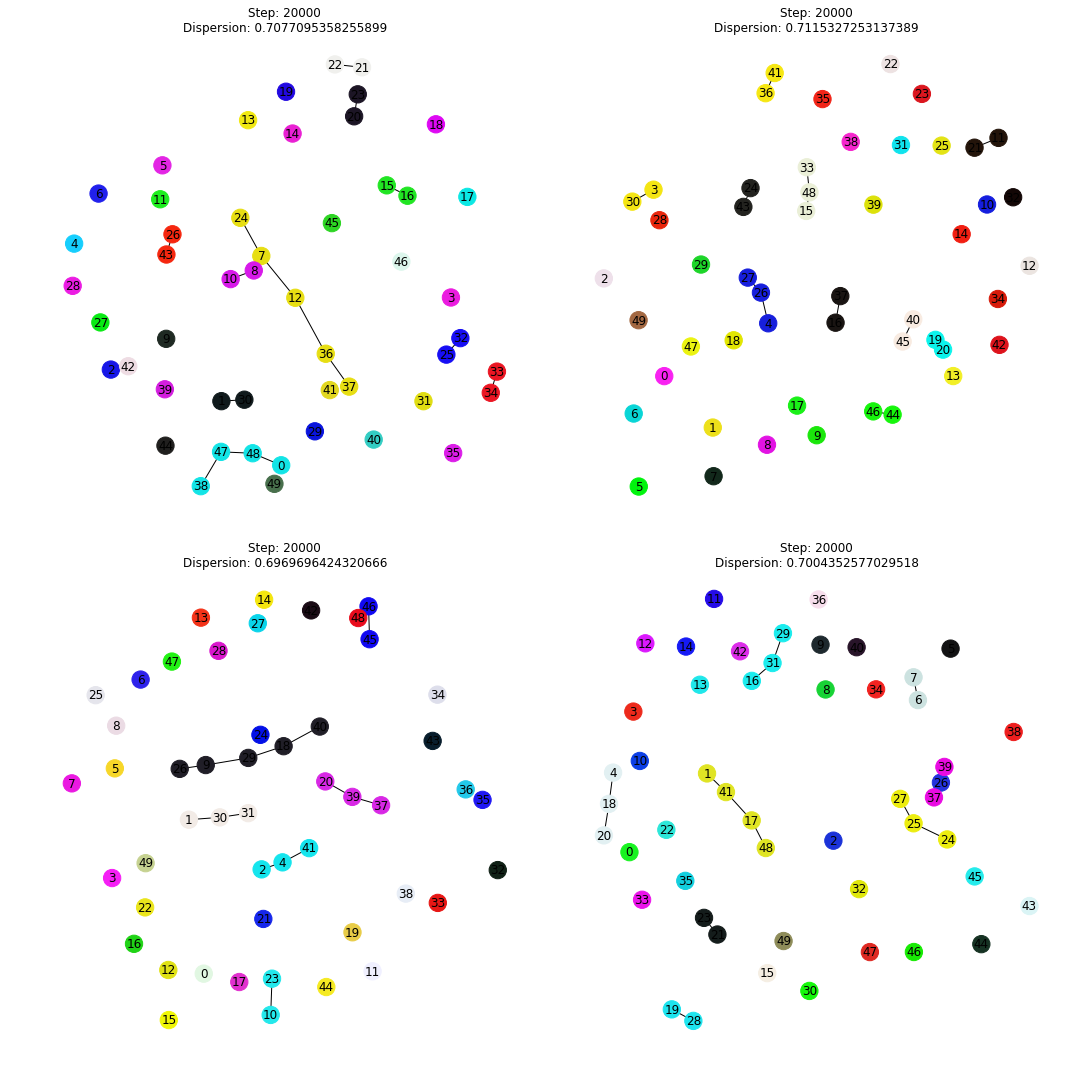

In [1432]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

for i,ax in enumerate(axes.flatten()):
    sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=7.89,delta=7.5,correlated = 0.4, p_add = 0.001)
    sim.initialize()

    for i in range(20000):
        sim.update()
    #plt.figure()
    sim.observe_custom(ax)


plt.tight_layout()
plt.show()


Answer: While the number of connected components with three nodes or more is higher than at the core of the basins of either attractor, most elements cannot find a group they can belong to.  However, we can visually observe that there are several nodes that could easily group together, but are not having the opportunity to get to know each other. I will test the effect of increasing the probability of creating a new edge on the structural metrics plotted above.

### Question 6: Does increasing the probability of adding a node lead to more large clusters, fewer disconnected individuals while preserving different opinions?



Probability of adding a new edge: 0.005


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in double_scalars


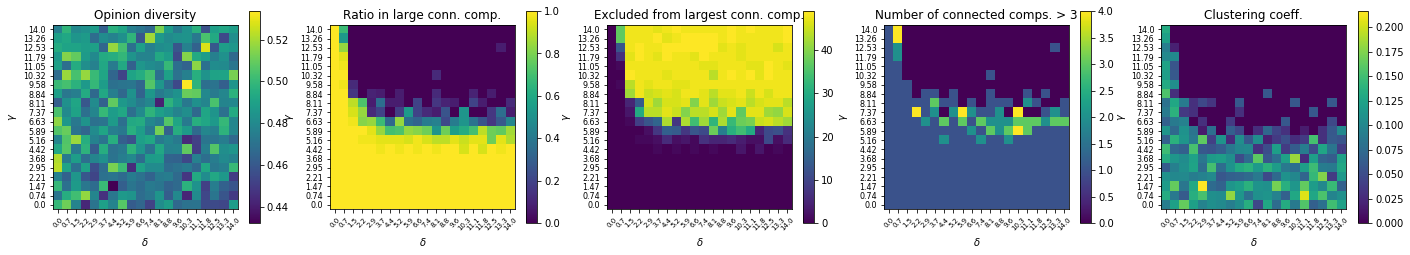

Probability of adding a new edge: 0.1


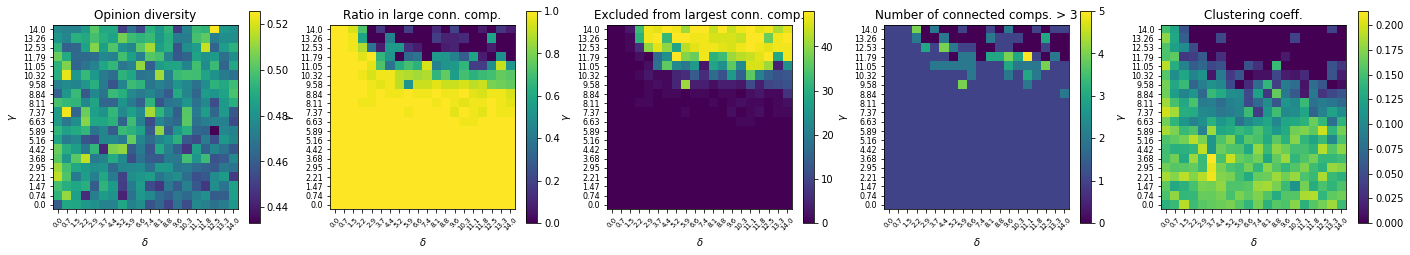

Probability of adding a new edge: 0.2


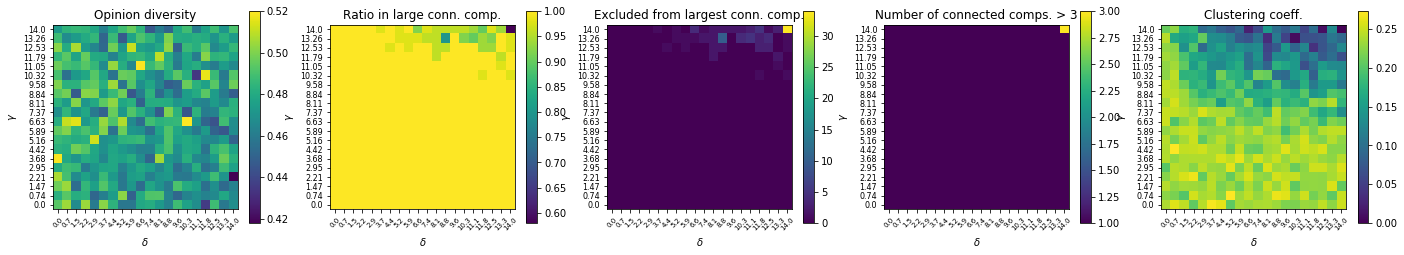

Probability of adding a new edge: 0.3


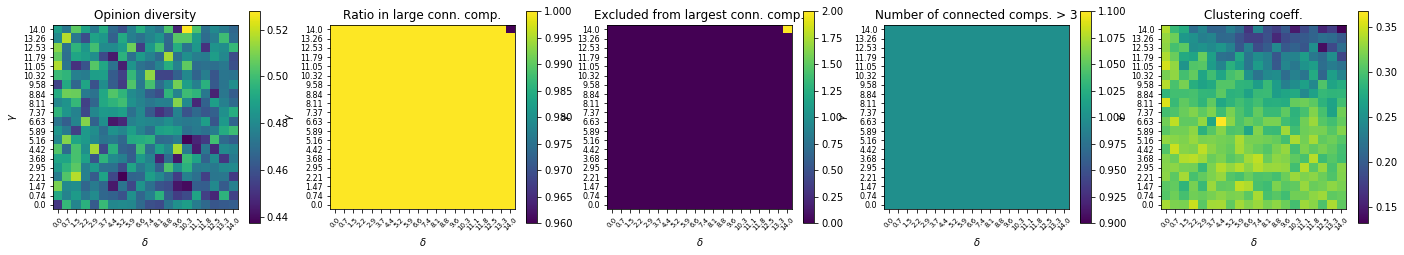

In [10]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
padds = [0.005, 0.1, 0.2, 0.3]
correl=0.9

for k,p in enumerate(padds):
    print('Probability of adding a new edge: '+str(p))
    dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
    in_large_comp = np.zeros((gammas.shape[0],deltas.shape[0]))
    largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
    avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
    nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
    clus = np.zeros((gammas.shape[0],deltas.shape[0]))

    for i,g in enumerate(gammas):
            for j,d in enumerate(deltas):
                sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                       network_size=50, only_most_agreed = True,
                                                       normal_sampling = True, p_add = p)
                sim.initialize()
                for _ in range(1000):
                    sim.update()

                try:
                    dispersions[i,j] = sim.dispersion()
                except:
                    dispersions[i,j] = 0

                largest_components[i,j] = sim.len_out_largest_comp()
                avgdegs[i,j] = sim.average_degree()
                in_large_comp[i,j] = sim.in_large_conn_component()
                nlcs[i,j] = sim.n_large_connected_components()
                clus[i,j] = nx.average_clustering(sim.graph)


    metrics = np.array([dispersions, in_large_comp, largest_components,nlcs,clus])
    titles = ['Opinion diversity', 'Ratio in large conn. comp.', 'Excluded from largest conn. comp.', 'Number of connected comps. > 3', 'Clustering coeff.']
    imshows = ['','','','','']

    fig, axes = plt.subplots(1,5,figsize=(24,26))
    for i,ax in enumerate(axes.flatten()[:6]):
        imshows[i] = ax.imshow(metrics[i],origin='lower')
        ax.set_xticks(range(len(deltas)))
        ax.set_yticks(range(len(gammas)))

        ax.set_xlabel(r'$\delta$')
        ax.set_ylabel(r'$\gamma$')

        ax.set_title(titles[i])

        ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
        ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
    for i,ax in enumerate(axes.flatten()):
        plt.colorbar(imshows[i], ax=ax,shrink=0.15)

    # #plt.tight_layout()
    plt.show()




To find a a simulation where multiple clusters of different colors are formed and few nodes are left alone,
the optimal candidate set of parameters should follow the following conditions: 

* almost all nodes should be included in a large component (not blue on the first column)
* should have many elements excluded from the largest component, since we want competing clusters (not green on the second column)
* at least 4 large connected componets (green or green square on the third column)

There is no consistent set of parameters that fulfills these conditions.

However, a more realistic endeavor would be finding a set of parameters that creates a large connected component with high opinion diversity and low clustering, where smaller subcomponents would be more clustered and homogeneous, analogous to the empirical social networks of systems such as classrooms and work spaces. For this purpose, I will run a simulation with p = 0.03, with parameters such that the clustering coefficient is low (upper right in the last column).

### Question 7: Are diverse opinions preserved when all or almost all individuals are part of the same connected component?

To evaluate what bonds individuals within a connected component, I will color each edge with the color of the opinion component that each two nodes disagree the least on, assuming that topic "bonds them".

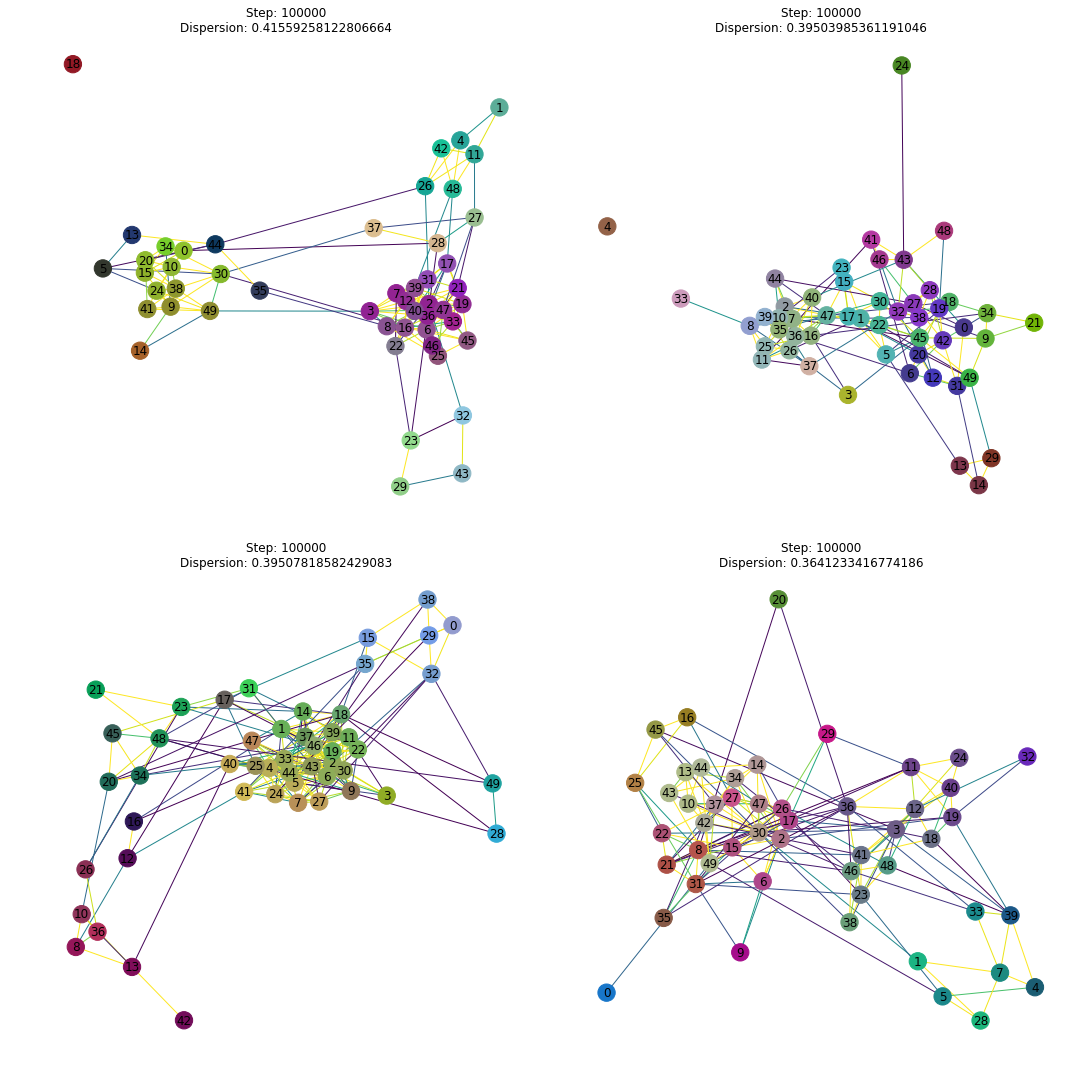

In [147]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

for i,ax in enumerate(axes.flatten()):
    sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=7,delta=10,
                                           correlated = 0.4, p_add = 0.015, 
                                           normal_sampling = True, only_most_agreed = True,
                                          colored_edges = True)
    #sim = MultivarSocialDynamicsSimulation(alpha=0.075, beta=0.3, gamma=11.5,delta=1.5,correlated = 0.4, p_add = 0.02)
    sim.initialize()

    for i in range(100000):
        sim.update()
    #plt.figure()
    sim.observe_custom(ax, layout='spring')


plt.tight_layout()
plt.show()




As it can be observed, while there is a single large connected component, diversity in opinions is largely maintained by the coexistence of subcomponents who are largely homogeneous. These subcomponents, defined as connected subgraphs of the main connected subcomponent that have approximately the same color and are bonded by the same opinion component, are glued to the supercommunity by a different opinion than the one which holds each subcommunity together. This is analogous to, e.g. both conservatives and liberals sharing a common feeling of love for their country.


## Discussion

While the prior model was mainly focused on testing the compatibility between two cultures in a closed system, the current extension drove its focus towards systems which are not initially polarized despite existing opposing views, such as a university campus. Due to the small world nature of such social networks, it was not the intention of this model to test for community splits, but to study and reproduce how first impressions are circumstancial (stochastic) and depend on how foreign someone is overall (modeled here as the Euclidean distance), and can determine the fate of a relationship/interaction.

This model has successfully captured several aspects of real social networks, such as
* multidimensionality in people's view of the world
* independent evolution of ideas
* influence of general difference on people's capabilities to interact with others irrespective of how much they agree on one topic
* people's ability to avoid confrontation by focusing on topics of mutual agreement.
* the coexistence of stable different opinions in social networks

Unfortunately, the critical points found through the local analysis were not reproducible to the global scale. This suggests that the simplifying assumptions made for the local analysis were not sustainable as the interactions scaled up, and that the global state of the network was not composable from the local interactions alone.

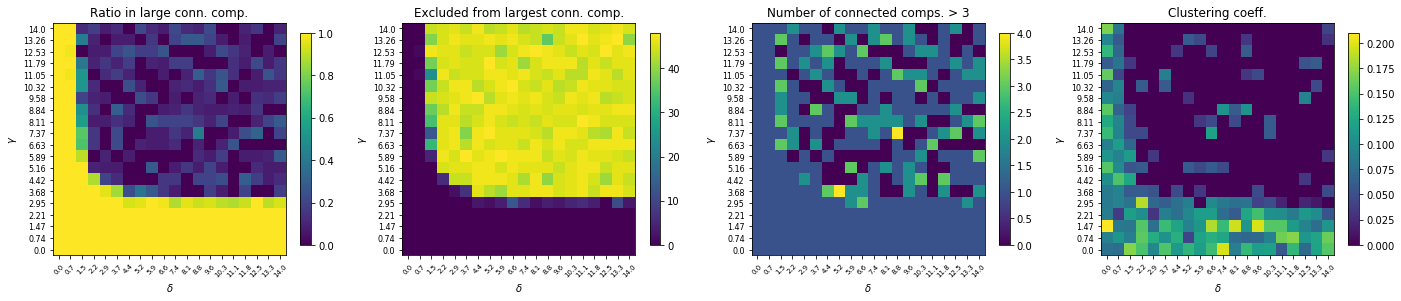

In [1456]:
gammas = np.linspace(0,14,20)
deltas = np.linspace(0,14,20)
correl=0.9

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))
largest_components = np.zeros((gammas.shape[0],deltas.shape[0]))
avgdegs = np.zeros((gammas.shape[0],deltas.shape[0]))
nlcs = np.zeros((gammas.shape[0],deltas.shape[0]))
clus = np.zeros((gammas.shape[0],deltas.shape[0]))
in_large_comp = np.zeros((gammas.shape[0],deltas.shape[0]))



for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = MultivarSocialDynamicsSimulation(gamma=g,delta=d,correlated=correl,
                                                   network_size=50, only_most_agreed = True,
                                                   normal_sampling = True)
            sim.initialize()
            for _ in range(1000):
                sim.update()
                
            try:
                dispersions[i,j] = sim.dispersion()
            except:
                dispersions[i,j] = 0
            
            largest_components[i,j] = sim.len_out_largest_comp()
            in_large_comp[i,j] = sim.in_large_conn_component()
            avgdegs[i,j] = sim.average_degree()
            nlcs[i,j] = sim.n_large_connected_components()
            clus[i,j] = nx.average_clustering(sim.graph)
        
        print('{}% done'.format(str((i+1)*100/len(gammas))[:3]))

metrics = np.array([in_large_comp, largest_components,nlcs,clus])
titles = ['Ratio in large conn. comp.', 'Excluded from largest conn. comp.', 'Number of connected comps. > 3', 'Clustering coeff.']
imshows = ['','','','']

fig, axes = plt.subplots(1,4,figsize=(24,26))
for i,ax in enumerate(axes.flatten()[:6]):
    imshows[i] = ax.imshow(metrics[i],origin='lower')
    ax.set_xticks(range(len(deltas)))
    ax.set_yticks(range(len(gammas)))
    
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel(r'$\gamma$')
    
    ax.set_title(titles[i])
    
    ax.set_xticklabels([round(d,1) for d in deltas],fontsize=7, rotation = 45)
    ax.set_yticklabels([round(g,2) for g in gammas],fontsize=8)
for i,ax in enumerate(axes.flatten()):
    plt.colorbar(imshows[i], ax=ax,shrink=0.15)

# #plt.tight_layout()
plt.show()




As it can be observed in the plot above,

In [198]:
np.linspace(0.1,0.9,4)

array([0.1       , 0.36666667, 0.63333333, 0.9       ])

In [1194]:
gammas = np.linspace(0,10,10)
deltas = np.linspace(0,10,10)
correl = np.linspace(0,0.9,10)

dispersions = np.zeros((gammas.shape[0],deltas.shape[0]))

fig, axes = plt.subplots(2,5,figsize=(15,10))

for k,ax in enumerate(axes.flatten()):
    start = time.time()
    for i,g in enumerate(gammas):
        for j,d in enumerate(deltas):
            sim = SocialDynamicsSimulation(gamma=g,delta=d,correlated=correl[k])
            sim.initialize()
            for _ in range(10000):
                sim.update()
            dispersions[i,j] = sim.dispersion()
    
    
    ax.imshow(dispersions,origin='lower',vmin=0,vmax=0.8)
    ax.set_xticks(range(0,10,1))
    ax.set_yticks(range(0,10,1))
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$\delta$')
    ax.set_title('Correlation between variables: {}'.format(str(correl[k])[:3]),fontsize=8)
    
    print('Colormap runtime: {}'.format(time.time()-start))
#plt.tight_layout()
plt.subplots_adjust(hspace=-0.45,wspace=0.3)#0.01,0.4,0.1,0.5)
#plt.colorbar(plt.imshow(dispersions,vmin=0,vmax=0.8))
plt.show()




#plt.colorbar()



/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [273]:
beta=0.3
gamma= 2
diff = 0.2

w = 0.9
(beta*(w-1) + 52.1735) /(beta * abs(diff) * (w -1))

#quotient = math.log10(10*beta*diff*gamma*w - 10*beta*diff*gamma - 10*beta*w + 10*beta + 1)/(math.log10(2) + math.log10(5))
#quotient 

-8690.583333333336